2025-04-17 12:04:26,256 Timor INFO Loading custom configurations from /home/mscsim/.config/timor.config
2025-04-17 12:04:26,789 Timor INFO Getting robot modrob-gen2.
2025-04-17 12:04:26,791 Timor WARNING Could not fetch robot modrob-gen2 due to [Errno 17] File exists: '/home/mscsim/anaconda3/envs/timor-env/lib/python3.10/site-packages/cache/robots/modrob-gen2'.


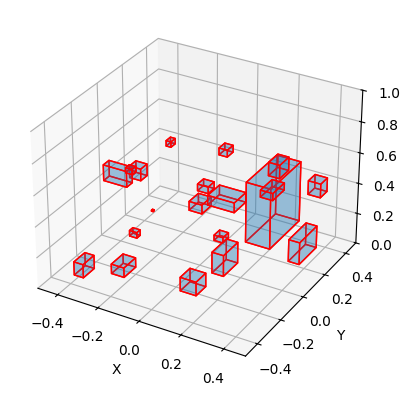

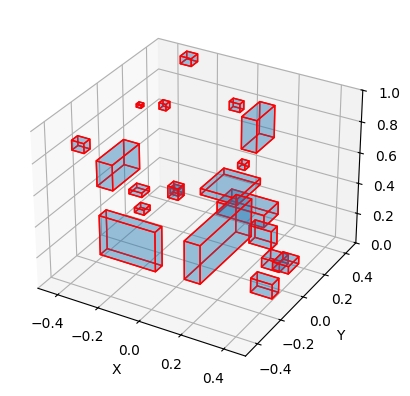

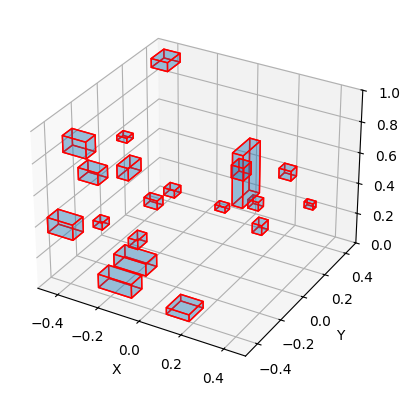

In [1]:
import numpy as np
import timor
import argparse
import pygad
import os
from util import *
from timor.Module import *
from timor.utilities.visualization import animation
# import matplotlib.pyplot as plt
# import itertools
# from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from timor import ModuleAssembly, ModulesDB
from timor.Bodies import Body, Connector, Gender
from timor.configuration_search.GA import GA
from timor.utilities.visualization import MeshcatVisualizer, clear_visualizer
from timor.utilities.dtypes import Lexicographic
from timor.utilities.transformation import Transformation
from timor.utilities.spatial import rotX, rotY, rotZ
from timor.Module import AtomicModule, ModulesDB, ModuleHeader
from timor.Joints import Joint
from timor.Geometry import Box, ComposedGeometry, Cylinder, Sphere, Mesh

from timor_ga import *
from reachability import Reachability
from generate_module import create_i_links, create_eef, create_revolute_joint, base, generate_i_links

how_many_times_to_split_angle_range = 30
world_resolution = 0.01
world_dimension = [1.00, 1.00, 1.00]
num_threads = 5
our_hyperparameters = {
    'population_size': 30,
    'num_generations': 100,
    'num_genes': 9,
    'save_solutions_dir': None
}

In [3]:
r_430_joint = create_revolute_joint("assets/430_joint/430_joint/urdf/430_joint.urdf")
r_330_joint = create_revolute_joint("assets/330_joint/330_joint/urdf/330_joint.urdf")
r_540_joint = create_revolute_joint("assets/540_joint/540_joint/urdf/540_joint.zip.urdf")
r_540_base = create_revolute_joint("assets/540_base/540_base/urdf/540_base.urdf")

# Links
generated_links = generate_i_links(r_540_base, [r_540_joint, r_330_joint, r_430_joint])
#print(generated_links.all_module_ids)

eef = create_eef()

# Create database
db = ModulesDB()
db.add(r_330_joint)
db.add(r_430_joint)
db.add(r_540_joint)
db.add(r_540_base)

db = db.union(generated_links)

db = db.union(eef)
viz = db.debug_visualization()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [6]:
import dill
with open('db.pkl', 'rb') as f:
    db_dict = dill.load(f)
print(db_dict)
db = ModulesDB.from_json_data(db_dict)
print(db.all_module_ids)

{'modules': [{'header': {'ID': '330_joint', 'name': 'continuous joint: 330_joint', 'date': '2025-04-17', 'author': 'Jonas Li, Jae Won Kim', 'email': 'liyunzhe.jonas@berkeley.edu', 'affiliation': 'UC Berkeley', 'cost': 0.0}, 'bodies': [{'ID': '330_jointAdaptor_Link', 'mass': 0.0172446569319253, 'inertia': [[3.81996295093174e-06, 3.08349257978459e-22, 1.23753267555244e-22], [3.08349257978459e-22, 4.03700901328837e-06, -1.70511681168816e-07], [1.23753267555244e-22, -1.70511681168816e-07, 3.04173251340529e-06]], 'r_com': [0.0, 0.000962217084485531, 0.0167038367716975], 'connectors': [{'ID': '330_jointAdaptor_Linkconnector', 'pose': [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]], 'gender': 'm', 'type': 'default', 'size': [0.025, 0.025]}], 'collision': [{'type': 'mesh', 'parameters': {'file': 'assets/330_joint/330_joint/meshes/Adaptor_Link.STL', 'scale': [1.0, 1.0, 1.0]}, 'pose': [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0

ValueError: modules.json invalid.

In [5]:

#modules = ('base_rev_joint', 'baseto4310-0.15', 'motor4310_rev_joint', 'r4310to4310-0.3', 'motor4310_rev_joint', 'r4310to4310-0.15', 'motor4310_rev_joint', 'r4310to4310-0.45', 'motor4310_rev_joint', 'r4310to4310-0.15', 'motor4310_rev_joint', 'r4310to4310-0.3', 'motor4310_rev_joint', 'eef')
#modules = ('540_base','baseto330_1-0.3', '330_joint', 'test-0.3', '330_joint', 'test-0.3', '330_joint')

#modules = ('540_base','540_base-to-330_joint-0.45-0-E', '330_joint', '330_joint-to-330_joint-0.45-3-W', '330_joint',  '330_joint-to-330_joint-0.15-3-N', '330_joint')
modules = ('540_base','540_base-to-540_joint-0.45-0-E', '540_joint', '540_joint-to-540_joint-0.15-0-E')#, '430_joint-to-330_joint-0.45-3-N', '330_joint',  '330_joint-to-540_joint-0.15-3-N', '540_joint')
modules = ('540_base', '540_base-to-330_joint-0.3-1-S', '330_joint', '330_joint-to-540_joint-0.3-1-N', '540_joint', '540_joint-to-330_joint-0.15-0-S', '330_joint', '330_joint-to-540_joint-0.45-1-E', '540_joint', '540_joint-to-330_joint-0.15-1-N', '330_joint', '330_joint-to-330_joint-0.3-1-S', '330_joint', '330_joint-to-330_joint-0.3-1-E', '330_joint', 'eef')
#modules = ('540_base','540_base-to-330_joint-0.45-0-E', '330_joint', '330_joint-to-330_joint-0.45-3-W', '330_joint',  '330_joint-to-330_joint-0.15-3-N', '330_joint', 'eef')

modules = ('540_base', '540_base-to-540_joint-0.15-3-S', '540_joint', '540_joint-to-540_joint-0.15-3-S', '540_joint', '540_joint-to-540_joint-0.3-0-W', '540_joint', '540_joint-to-330_joint-0.15-1-W', '330_joint', '330_joint-to-330_joint-0.15-1-N', '330_joint', '330_joint-to-330_joint-0.3-1-S', '330_joint', '330_joint-to-330_joint-0.15-0-W', '330_joint', 'eef')
modules = ('540_base','baseto430_2-0.3', '430_joint', 'test-0.15')
B = ModuleAssembly.from_serial_modules(db, modules)
print(num_incorrect_connections(B))
print(B.original_module_ids)
#print(B.nJoints)
robot = B.to_pin_robot()
print(robot.has_self_collision())
print(robot.data)
print(robot.joints)
viz = robot.visualize()


3
('540_base', 'baseto430_2-0.3', '430_joint', 'test-0.15')
False
['540_base.540_base', '430_joint.430_joint']
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [6]:
print(fitness_function(B, None, None))

Lexicographic (6030.0, -80, -160)


In [7]:
init_pop = [('540_base', '540_base-to-540_joint-0.3-3-E', '540_joint', '540_joint-to-540_joint-0.45-3-E', '540_joint', '540_joint-to-540_joint-0.3-1-S', '540_joint', '540_joint-to-540_joint-0.15-2-E', '540_joint', '540_joint-to-330_joint-0.45-3-N', '330_joint', '330_joint-to-330_joint-0.15-3-W', '330_joint', '330_joint-to-330_joint-0.15-2-S', '330_joint', 'eef'), ('540_base', '540_base-to-540_joint-0.3-2-N', '540_joint', '540_joint-to-540_joint-0.15-2-S', '540_joint', '540_joint-to-330_joint-0.45-1-E', '330_joint', '330_joint-to-330_joint-0.45-3-W', '330_joint', '330_joint-to-540_joint-0.15-3-W', '540_joint', '540_joint-to-540_joint-0.15-2-S', '540_joint', '540_joint-to-540_joint-0.15-2-S', '540_joint', 'eef'), ('540_base', '540_base-to-540_joint-0.15-3-E', '540_joint', '540_base-to-540_joint-0.15-3-E', '330_joint', '330_joint-to-330_joint-0.45-1-S', '330_joint', '330_joint-to-330_joint-0.45-1-S', '330_joint', '330_joint-to-540_joint-0.3-3-W', '540_joint', '540_joint-to-540_joint-0.3-0-E', '540_joint', '540_joint-to-540_joint-0.45-3-N', '540_joint', 'eef'), ('540_base', '540_base-to-330_joint-0.45-3-N', '330_joint', '330_joint-to-330_joint-0.15-0-S', '330_joint', '330_joint-to-330_joint-0.15-0-S', '540_joint', '540_joint-to-540_joint-0.15-3-N', '540_joint', '540_joint-to-330_joint-0.45-2-W', '330_joint', '330_joint-to-540_joint-0.3-1-S', '540_joint', '540_joint-to-330_joint-0.3-3-W', '330_joint', 'eef'), ('540_base', '540_base-to-540_joint-0.15-2-S', '540_joint', '540_base-to-540_joint-0.15-2-S', '540_joint', '540_base-to-540_joint-0.15-2-S', '330_joint', '330_joint-to-330_joint-0.3-3-S', '330_joint', '330_joint-to-540_joint-0.45-0-N', '540_joint', '540_joint-to-540_joint-0.15-0-E', '540_joint', '540_joint-to-330_joint-0.3-1-N', '330_joint', 'eef'), ('540_base', '540_base-to-540_joint-0.15-1-W', '540_joint', '540_joint-to-540_joint-0.3-0-E', '540_joint', '540_joint-to-540_joint-0.45-2-W', '540_joint', '540_joint-to-540_joint-0.15-3-E', '540_joint', '540_joint-to-330_joint-0.15-0-N', '330_joint', '330_joint-to-540_joint-0.3-3-E', '540_joint', '540_joint-to-540_joint-0.3-1-S', '540_joint', 'eef'), ('540_base', '540_base-to-330_joint-0.3-0-N', '330_joint', '330_joint-to-330_joint-0.15-1-W', '330_joint', '330_joint-to-540_joint-0.15-1-S', '540_joint', '540_joint-to-330_joint-0.15-2-N', '330_joint', '330_joint-to-540_joint-0.15-1-S', '540_joint', '330_joint-to-540_joint-0.15-1-S', '330_joint', '330_joint-to-540_joint-0.15-0-W', '540_joint', 'eef'), ('540_base', '540_joint-to-330_joint-0.3-0-E', '540_joint', '540_joint-to-330_joint-0.3-0-E', '540_joint', '540_joint-to-540_joint-0.3-3-E', '540_joint', '540_joint-to-330_joint-0.45-0-E', '330_joint', '330_joint-to-540_joint-0.45-3-N', '540_joint', '540_joint-to-540_joint-0.45-3-S', '540_joint', '540_joint-to-540_joint-0.15-0-E', '540_joint', 'eef'), ('540_base', '540_base-to-330_joint-0.3-2-S', '330_joint', '330_joint-to-540_joint-0.45-3-S', '540_joint', '540_joint-to-330_joint-0.15-3-W', '330_joint', '330_joint-to-330_joint-0.3-2-E', '330_joint', '330_joint-to-330_joint-0.3-2-E', '330_joint', '330_joint-to-330_joint-0.3-2-W', '330_joint', '330_joint-to-330_joint-0.3-2-W', '330_joint', 'eef'), ('540_base', '540_base-to-540_joint-0.3-1-W', '540_joint', '540_joint-to-540_joint-0.3-2-E', '540_joint', '540_joint-to-540_joint-0.3-2-N', '540_joint', '540_joint-to-540_joint-0.3-2-N', '330_joint', '330_joint-to-330_joint-0.45-2-W', '330_joint', '330_joint-to-330_joint-0.3-3-S', '330_joint', '330_joint-to-540_joint-0.15-2-E', '540_joint', 'eef')]
result = []
for pop in init_pop:
    C = ModuleAssembly.from_serial_modules(db, modules)
    result.append(fitness_function(C, None, None))
    print(result[-1])

Lexicographic (6010.0, -80, -160)
Lexicographic (6170.0, -80, -160)
Lexicographic (5960.0, -80, -160)
Lexicographic (5910.0, -80, -160)
Lexicographic (6010.0, -80, -160)
Lexicographic (6120.0, -80, -160)
Lexicographic (5780.0, -80, -160)
Lexicographic (5950.0, -80, -160)
Lexicographic (5770.0, -80, -160)
Lexicographic (6180.0, -80, -160)


In [8]:
from timor.utilities.visualization import animation
q0 = np.zeros((robot.dof,))
print(robot.dof)
q1 = robot.random_configuration()
q2 = np.array([np.pi, -np.pi/2, np.pi/2, np.pi/2])
print(q1)
robot.update_configuration(q1)
print(robot.has_self_collision())
viz = robot.visualize()
#print(q1)

trajectory = np.linspace(q0, q1)
# print(trajectory)
animation(robot, trajectory, dt=.1)

4
[-4.44765997  0.89446861  4.31026808 -6.24399647]
False
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [8]:
from reachability import Reachability
from timor_ga import *

# modules = ('base_rev_joint', 'baseto4310-0.15', 'motor4310_rev_joint', 
#            'r4310to4310-0.15', 'motor4310_rev_joint', 'r4310to4310-0.15', 
#            'motor4310_rev_joint', 'eef')
# modules = ('base_rev_joint', 'baseto4310-0.15', 'motor4310_rev_joint', 
#            'r4310to4310-0.15', 'motor4310_rev_joint', 'r4310to4310-0.15', 
#            'motor4310_rev_joint', 'r4310to4305-0.15', 'motor4310_rev_joint', 'r4310to4305-0.15', 'motor4305_rev_joint')
# C = ModuleAssembly.from_serial_modules(db, modules)

# robot = C.to_pin_robot()

how_many_times_to_split_angle_range = 30
world_resolution = 0.01
world_dimension = [1.00, 1.00, 1.00]
num_threads = 5

reach = Reachability(robot)
reach.reachability_random_sample(num_samples = 100000)
valid_poses = reach.reachability_random_sample(num_samples = 100000)
print("Valid poses:" , valid_poses)
reachable, manipulability =  zip(*valid_poses)
reachable = np.array([list(pt) for pt in reachable])
reachability_score = reach.find_reachibility_percentage(valid_pose=reachable)
print(reachability_score)


KeyboardInterrupt: 